# Synthesizing Birdsong

#### MAE 4760, Spring 2021, Adams/Land

In [1]:
import numpy
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.display import Image
from scipy import signal
from scipy.fft import fftshift
from scipy.io import wavfile
plt.rcParams['figure.figsize'] = [12, 4]
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Webpage table of contents

> - [Background and Introduction](#Background-and-Introduction)
> - [Deconstructing the Song](#Deconstructing-the-song)
> > - [Swoop Analysis](#Swoop-Analysis)
> > - [Swoop Simulation](#Swoop-Simulation)
> > - [Chirp Analysis](#Chirp-Analysis)
> > - [Chirp Simulation](#Chirp-Simulation)
> > - [Silence](#Silence)
> > - [Assembling the Song](#Assembling-the-song)
> - [Hardware](#Hardware)
> - [Software](#Software)
> - [Programmer](#Programmer)
> - [Procedure](#Procedure)
> - [Relevant Resources](#Relevant-resources)
> > - [Python Interface](#Python-interface)
> > - [DAC and audio output](#DAC-and-audio-output)
> > - [Sound synthesis](#Sound-synthesis)
> - [Program Organization and Debugging](#Program-Organization-and-Debugging)
> - [Weekly Checkpoints and Lab Report Specifications](#Weekly-Checkpoints-and-Lab-Report)
> > - [Week one](#Week-one-required-checkpoint)
> > - [Week two](#Week-two-assignment)
> > - [Opportunities to keep going](#Opportunities-to-keep-going)
> > - [Lab Report](#Lab-report)
> - [Demonstrations of Working System (for reference)](#Demonstrations-of-working-system)


## Background and Introduction

We will be using direct digital synthesis to generate the call of the northern cardinal. Specifically, [this](https://macaulaylibrary.org/asset/130905?__hstc=75100365.b8a8ce99cbef50e187883000d2a8e38b.1601856173825.1602249083165.1603396221676.6&__hssc=75100365.1.1603396221676&__hsfp=2840701297#_ga=2.15404978.520534262.1603396221-116006615.1601856172) adult male northern cardinal recorded by Gerrit Vyn in 2006. This bird was recorded in Texas, but cardinals are also common in Ithaca and throughout the eastern United States. If you pay attention when you're walking through campus, you may hear one singing. The males are a very striking red. You can read more about the cardinal [here](https://www.allaboutbirds.org/guide/Northern_Cardinal).

<figure>
    <img align="center" width="500" height="500" src="cardinal.jpg" alt='missing' />
    <center><figcaption>A northern cardinal</figcaption></center>
</figure>

Cardinals have a variety of songs and calls. We will be synthesizing on of its most common songs, which you can hear in the first ten seconds of the recording below:

<iframe align="center" width="800" height="356" src="https://macaulaylibrary.org/asset/130905/embed/640" frameborder="0" allowfullscreen style="width:800px;"></iframe>

Here is a screenshot of the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) for the song that we'll be synthesizing. Cardinals and many other songbirds produce almost pure frequency-modulated tones. As can be seen in the spectrogram below, the cardinal sweeps through frequencies from ~2kHz to ~7kHz. We'll assume that the dominant tones  (the darkest lines on the spectrogram) are significantly louder than all other frequencies (the lighter lines). We'll only synthesize these loudest frequencies. The generated song sounds quite realistic under this assumption. Your synthesizer will be controlled via a Python-based user interface.

<img align="center" width="1000" height="1000" src="spectrogram.png">

***

## Deconstructing the song

This song can be decomposed into three sound primitives: a low-frequency swoop at the beginning of each call, a chirp after each swoop which moves rapidly from low frequency to high frequency, and silence which separates each swoop/chirp combination. We will synthesize each of these primitives separately, and then compose them to reconstruct the song.

### Swoop

#### Swoop Analysis

By pasting the above spectrogram in Keynote and drawing lines on it, you can determine that the length of the chirp is approximately 130 ms. Since the DAC gathers audio samples at 44kHz, this means that the chirp lasts for $0.130\text{sec} \cdot \frac{44000\text{ samples}}{1\text{ sec}} = 5720\text{ samples}$. We'll approximate the frequency curve by sine wave of the form:

\begin{align}
y = k\sin{mx} + b
\end{align}

where $y$ is the frequency in Hz, and $x$ is the number of audio samples since the chirp began. Since the swoop starts and ends at 1.74kHz and peaks at 2kHz, we can setup the following system of equations to solve for the unknown parameters $k$, $b$, and $m$:

\begin{align}
1740 &= k\sin{m\cdot 0} + b\\
1740 &= k\sin{m\cdot 5720} + b\\
2000 &= k\sin{m\cdot 2860} + b
\end{align}

From which we can find $b=1740$, $k = -260$, $m = \frac{-\pi}{5720}$. So, the equation is given by:

\begin{align}
y = -260 \sin{\left(-\frac{\pi}{5720} \cdot x\right)} + 1740
\end{align}

Plot the simulated swoop of frequencies:

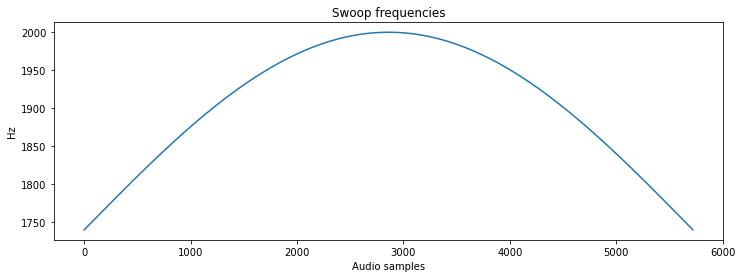

In [2]:
plt.plot(-260*numpy.sin(-numpy.pi/5720*numpy.arange(5720)) + 1740)
plt.xlabel('Audio samples'); plt.ylabel('Hz'); plt.title('Swoop frequencies')
plt.show()

#### Swoop Simulation

Some DDS parameters, including the sample rate (44kHz), a 256-entry sine table, and the constant $2^{32}$:

In [3]:
Fs = 44000 #audio sample rate
sintable = numpy.sin(numpy.linspace(0, 2*numpy.pi, 256))# sine table for DDS
two32 = 2**32 #2^32

And now we can synthesize audio samples.

In [4]:
swoop = list(numpy.zeros(5720)) # a 5720-length array (130ms @ 44kHz) that will hold swoop audio samples
DDS_phase = 0 # current phase
for i in range(len(swoop)):
    frequency = -260.*numpy.sin((-numpy.pi/5720)*i) + 1740 # calculate frequency
    DDS_increment = frequency*two32/Fs # update DDS increment
    DDS_phase += DDS_increment # update DDS phase by increment
    DDS_phase = DDS_phase % (two32 - 1) # need to simulate overflow in python, not necessary in C
    swoop[i] = sintable[int(DDS_phase/(2**24))] # can just shift in C

In order to avoid non-natural clicks, we must ramp the amplitude smoothly from 0 to its max amplitude, and then ramp it down. We'll do this by multiplying the chirp by the linear ramp function shown below:

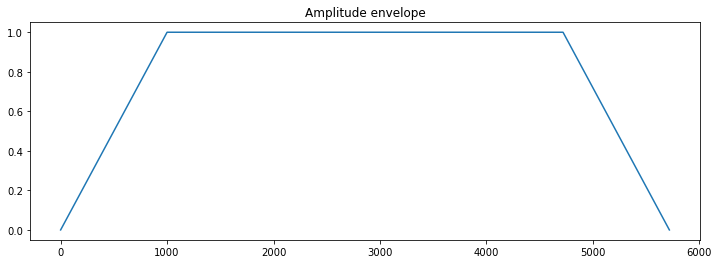

In [5]:
# Amplitude modulate with a linear envelope to avoid clicks
amplitudes = list(numpy.ones(len(swoop)))
amplitudes[0:1000] = list(numpy.linspace(0,1,len(amplitudes[0:1000])))
amplitudes[-1000:] = list(numpy.linspace(0,1,len(amplitudes[-1000:]))[::-1])
amplitudes = numpy.array(amplitudes)
plt.plot(amplitudes);plt.title('Amplitude envelope');plt.show()

# Finish with the swoop
swoop = swoop*amplitudes

Here is what the swoop looks like:

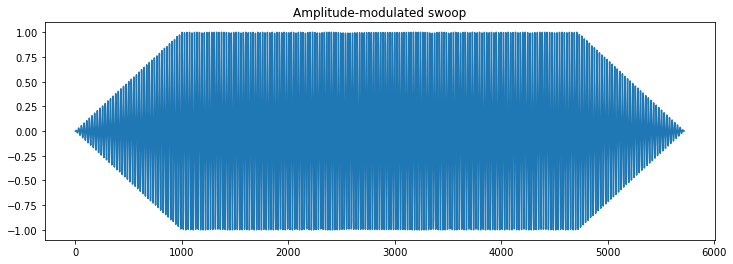

In [6]:
plt.plot(swoop);plt.title('Amplitude-modulated swoop');plt.show()

And here is what it sounds like:

In [7]:
Audio(swoop, rate=48000)

### Chirp

#### Chirp Analysis

By pasting the above spectrogram in Keynote and drawing lines on it, you can determine that the length of the chirp is also approximately 130 ms (5720 samples). We'll approximate the frequency curve by a quadratic equation of the form:

\begin{align}
y = kx^2 + b
\end{align}

where $y$ is the frequency in Hz, and $x$ is the number of audio samples since the chirp began. Since the chirp starts at 2kHz and ends at 7kHz, we can setup the following system of equations to solve for the unknown parameters $k$ and $b$:

\begin{align}
2000 &= k(0^2) + b\\
7000&= k(5720^2) + b
\end{align}

This is two equations with two unknowns. Solving, we find that $b=2000$ and $k\approx 1.53 \times 10^{-4}$. So the quadratic equation for the chirp is:

\begin{align}
y &= \left(1.53\times 10^{-4}\right)x^2 + 2000 && \text{for $x\in[0, 5720]$}
\end{align}

Plot the simulated chirp frequency sweep:

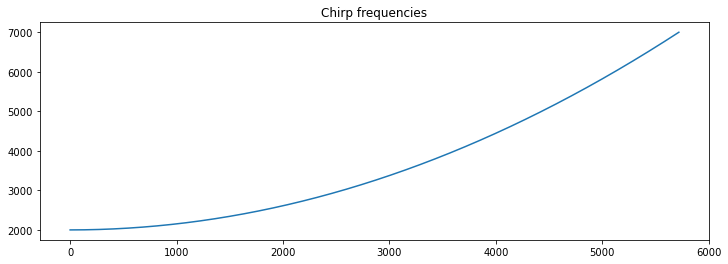

In [8]:
plt.plot(1.53e-4 * numpy.arange(5720)**2. + 2000);plt.title('Chirp frequencies');plt.show()

#### Chirp Simulation

And now we can synthesize audio samples.

In [9]:
chirp = list(numpy.zeros(5720)) # a 5720-length array (130ms @ 44kHz) that will hold chirp audio samples
DDS_phase = 0 # current phase
for i in range(len(chirp)):
    frequency = (1.53e-4)*(i**2.) + 2000 # update DDS frequency
    DDS_increment = frequency*two32/Fs # update DDS increment
    DDS_phase += DDS_increment # update DDS phase
    DDS_phase = DDS_phase % (two32 - 1) # need to simulate overflow in python, not necessary in C
    chirp[i] = sintable[int(DDS_phase/(2**24))] # can just shift in C

In order to avoid non-natural clicks, we must ramp the amplitude smoothly from 0 to its max amplitude, and then ramp it down. We'll do this by multiplying the chirp by the linear ramp function shown below:

In [10]:
# Amplitude modulate with a linear envelope to avoid clicks
amplitudes = list(numpy.ones(len(chirp)))
amplitudes[0:1000] = list(numpy.linspace(0,1,len(amplitudes[0:1000])))
amplitudes[-1000:] = list(numpy.linspace(0,1,len(amplitudes[-1000:]))[::-1])
amplitudes = numpy.array(amplitudes)

# Finish with the chirp
chirp = chirp*amplitudes

The entire amplitude-modulated chirp looks like this:

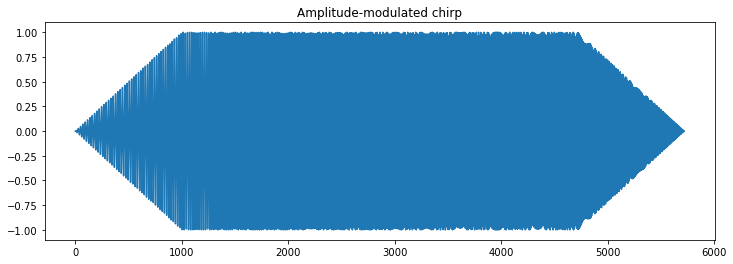

In [11]:
plt.plot(chirp);plt.title('Amplitude-modulated chirp');plt.show()

And it sounds like this:

In [12]:
Audio(chirp, rate=44000)

### Silence

The amount of time between swoop/chirps is also (approximately) 130ms or 5720 cycles.

In [13]:
silence = numpy.zeros(5720)

### Assembling the song

We assemble the song by playing the swoop/chirp/silence in succession:

In [14]:
song = []
for i in range(5):
    song.extend(list(swoop))
    song.extend(list(chirp))
    song.extend(list(silence))
song.extend(list(swoop))
song.extend(list(chirp))
song.extend(list(silence))
song = numpy.array(song)

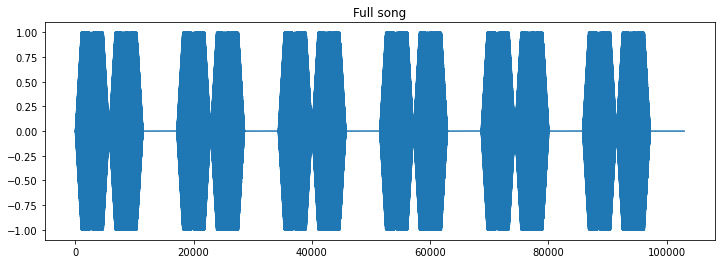

In [15]:
plt.plot(song);plt.title('Full song');plt.show()

Listen to it:

In [16]:
Audio(song, rate=44000)

And view the spectrogram of the Python-generated song:

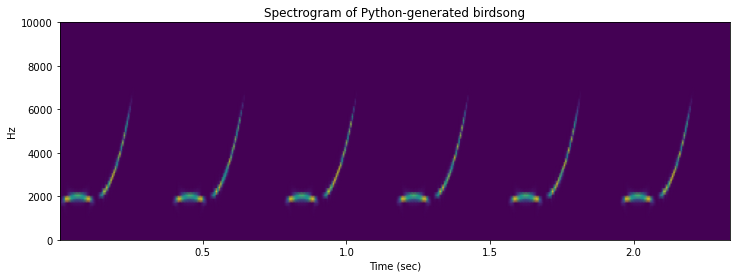

In [17]:
f, t, Sxx = signal.spectrogram(song, Fs)
plt.pcolormesh(t, f, Sxx,  shading='gouraud')
plt.ylabel('Hz'); plt.xlabel('Time (sec)')
plt.title('Spectrogram of Python-generated birdsong')
plt.ylim([0,10000])
plt.show()

***

## Hardware

The *Big Board* which you will be using features a [port expander](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/port_expander.pdf), [DAC](http://www.microchip.com/wwwproducts/en/MCP4822), TFT header-socket, programming header-plug, and power supply. See the [construction page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html) for specific code examples of each device on the big board. The connections from the PIC32 to the various peripherals is determined by the construction of the board. The list is repeated here.

#### PIC32 i/o pins used on the big board, sorted by port number

Any pin can be recovered for general use by unplugging the device that uses the pin (of course, if you're doing this lab remotely, you will not be able to unplug these devices). SPI chip select ports have jumpers to unplug.

`RA0 on-board LED. Active high.`<br>
`RA1 Uart2 RX signal, if serial is turned on in protothreads 1_2_2`<br>
`RA2 port expander intZ`<br>
`RA3 port expander intY` <br>
`RA4 PortExpander SPI MISO`<br>
`-----` <br>
`RB0 TFT D/C` <br>
`RB1 TFT-LCD SPI chip select (can be disconnected/changed)`<br>
`RB2 TFT reset` <br>
`RB4 DAC SPI chip select (can be disconnected/changed)`<br>
`RB5 DAC/PortExpander SPI MOSI` <br>
`RB6 !!! Does not exist on this package!!! (silk screen should read Vbus)` <br>
`RB9 Port Expander SPI chip select (can be disconnected/changed)`<br>
`RB10 Uart2 TX signal, if serial is turned on in protothreads 1_2_2`<br>
`RB11 TFT SPI MOSI` <br>
`RB12 !!! Does not exist on this package!!! (silk screen should read Vusb3.3)`<br> 
`RB14 TFT SPI Sclock` <br>
`RB15 DAC/PortExpander SPI Sclock`

But note the few silk-screen errors on the board.

**SECABB version 2 silk screen errors.** (fixed on version 2.1)

- Edge connector pin marked RB6 -- RB6 does not exist on this package! Silk screen should read Vusb.
- Edge connector marked RB12 -- RB12 does not exist on this package! Silk screen should read Vusb3.3
- LED D1 outline -- Silk screen should have flat side should be oriented toward PIC32

#### Scope Connections

- Probe 1 $\leftrightarrow$ `DACA`
- Probe 2 $\leftrightarrow$ `DACB`

***

## Software

Software you will use is freely downloadable and consists of:

- [MPLABX](http://www.microchip.com/pagehandler/en-us/family/mplabx/) version 3.05 (see the *Downloads Archive*)
- [XC32](http://www.microchip.com/mplab/compilers) compiler version 1.40 (see the *Downloads Archive*)
- [plib](http://www.microchip.com/mplab/compilers) (near bottom of page choose *Downloads --> Scroll to bottom)

(All of this is already installed on the lab PC's). More information can be found at the links below.

- [Getting started with PIC32](http://ww1.microchip.com/downloads/en/DeviceDoc/61146B.pdf)
- [MPLABX IDE users guide](http://ww1.microchip.com/downloads/en/DeviceDoc/50002027E.pdf)
- [32 bit peripherals library](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/32-bit-Peripheral-Library-Guide.pdf) -- [PLIB examples](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/PLIB_examples/plib_examples/)
- [32 bit language tools and libraries](http://ww1.microchip.com/downloads/en/DeviceDoc/51685E.pdf) including C libraries, DSB, and debugging tools
- [XC32 Compiler Users Guide](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/mplab-xc32-users-guide.pdf)
- [PIC32MX2xx datasheet](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/2xx_datasheet.pdf) -- [Errata](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Erata_PIC32MX.pdf)
- [MicrostickII pinout](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Microstick_pinput.pdf)
- [PIC32MX250 configuration options](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/32mx250f128b.html)
> - JTAG enable overrides pins 13, 14, and 15
> - Primary oscillator enable overrides pins 9 and 10
> - Secondary oscillator enable overrides pins 11 and 12
- [PIC32 reference manual](http://hades.mech.northwestern.edu/images/2/21/61132B_PIC32ReferenceManual.pdf)
> - This is **huge**, better to go to the [PIC32 page](http://www.microchip.com/pagehandler/en-us/family/32bit/) then Documentation --> Reference Manual and choose the section
- **Specific pages from the PIC32 datasheet**
> - PIC32MX250F128B [PDIP pinout](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/PIC32MX250F128B_pinput.PNG) by pin
> - PIC32MX250F128B:: **Signal Names** $\rightarrow$ **Pins**::[1](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Pinput_name_table_1_1_1.PNG), [2](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Pinput_name_table_1_1_2.PNG), [3](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Pinput_name_table_1_1_3.PNG), [4](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Pinput_name_table_1_1_4.PNG), [5](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Pinput_name_table_1_1_5.PNG), [6](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Pinput_name_table_1_1_6.PNG), [7](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/Pinput_name_table_1_1_7.PNG) PDIP highlighted in green (for **PPS** see next tables)
> - PIC32MX250F128B [Peripheral Pin Select (PPS) input table](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/PPS_inputs_table_11_1.PNG)
> > - Example: UART receive pin ::: specify PPS group, signal, logical pin name<br> `PPSInput(2, U2RX, RPB11);`<br> `// Assign U2RX to pin RPB11 - Physical pin 22 on 28 PDIP`
> - PIC32MX250F128B [Peripheral Pin Select (PPS) output table](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/PPS_outputs_table11_2.PNG)
> > - Example: UART transmit pin ::: specify PPS group, logical pin name, signal<br> `PPSOutput(4, RPB10, U2TX);`<br> `// Assign U2TX to pin RPB10 - Physical pin 21 on 28 PDIP`

Oscilloscope software:

- See [this webpage](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_remote.html)

***

## Programmer

#### Microstick2 as a programmer

The connections to the microcontroller socket on the Microstick2 act like the [standard programming signals](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/pickit3_connections.PNG) from the [PICKIT3](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Microchip_stuff/pickit3_users_guide.pdf), the programmer which was used to develop the boards you will be using. On both the big and small boards, J1 marks pin1 of the 6-pin ICSP header.

| Signal | PICkit3 (ICSP)<br>connector on board | Microstick2<br>DIP Pins |
| :- | :-: | :-: |
| MCLR | 1 | 1
|ground| 3 | 27
|prog data (PGD) | 4 | 4
|prog clock (PGC) | 5 | 5

A wiring example is shown below. Note that pin 1, MCLR, is only available on the Microstick2 DIP socket as shown.

<figure>
    <img align="center" width="400" height="400" src="microstick_pgmer_1.jpg" alt='missing' />
</figure>

<figure>
    <img align="center" width="400" height="400" src="microstick_pgmer_2.jpg" alt='missing' />
</figure>

***

## Procedure

1. The current version of Protothreads is 1_3_2. All example programs using this threader may be found on the [Development board page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html#sw_for_SECABB). Download the ZIP file on this page to get all the libraries and substitute in the following source code: <br> Program example 3, **DDS_Accum_Expander_BRL4.c** on the [Development board page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html#sw_for_SECABB) is the basis for this lab.
2. For an example of controlling the PIC from a Python interface, see [the remote learning page](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_remote.html)
2. For most of the semester you will be using the TFT LCD for output and debugging. You will need to use some of the graphics library calls described in the test code in this lab.<br>Test code: [TFT_test_BRL4.c](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/Target_board/TFT_test_BRL4.c) -- displays color patches, system time, moves a ball, generates a slow ramp on the DAC, and blinks the LED
3. You may want to refer to the [ProtoThreads page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_Protothreads.html) for the general threading setup. 
4. Timing of all functions in this lab, **and every exercise in this course** will be handled by interrupt-driven counters, (including the builtin functions in ProtoThreads) and not by software wait-loops. This will be enforced because wait-loops are hard to debug and tend to limit multitasking. You may not use any form of a delay(mSec) function.
5. The oscilloscope is essential for debugging this lab (and every lab). The oscilloscope is the only way of deciding if -- It doesn't work! -- results from hardware or software.

***

## Relevant resources

#### Python interface

In this lab and in all subsequent labs, you will build a Python-based user interface for controlling the PIC. Please see [this page](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_remote.html) for examples of and information about the Python interface.

<figure>
    <img align="center" width="300" height="200" src="example.png" alt='missing' />
    <center><figcaption>Example of a Python interface. See link above.</figcaption></center>
</figure>

#### DAC and audio output

The SPI DAC you will use is the [MCP4822](http://people.ece.cornell.edu/land/courses/ece4760/labs/f2019/lab2_mcp4822.pdf). The DAC analog output is marked DACA or DACB on the SECABB. The SPI connections are supplied on the Big Board (SECABB), as long as you connect the DAC_CS jumper. Section 5.1 and 5.2 of the MCP4822 datasheet discussed the way the the DAC uses SPI. The edge connector pin marked DACA or DACB will go (optionally through a low pass filter) to an audio socket, to be connected to the green audio plug of the speakers. If you are going to design a lowpass filter for the DAC, then you need to know that the input impedance of the speakers is around 10 Kohm.

<figure>
    <img align="center" width="200" height="200" src="audio_socket.png" alt='missing' />
    <center><figcaption>Audio socket. The pin nearest the socket is ground. Left/right channels are wired together.</figcaption></center>
</figure>

<figure>
    <img align="center" width="200" height="200" src="audio_plug.png" alt='missing' />
    <center><figcaption>Speaker audio input plug.</figcaption></center>
</figure>

#### Sound synthesis

Generally speaking you want to make pleasant sounding synthesis. You may want to look at the [sound synthesis page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_sound_synth.html). I suggest starting with a linear attack of about 1000 samples, a decay of about 1000 samples, and a sustain as long as necessary for a 130ms chirp/swoop.

***

## Program Organization and Debugging

#### Program Organization

I suggest that you organize the program as follows. If a different organization makes more sense to you, that's ok. This is just a suggestion.

- **Protothreads** maintains the ISR-driven, millisecond-scale timing as part of the supplied system. Use this for all low-precision timing (can have several milliseconds jitter).
- **Synthesis ISR** uses a timer interrupt to ensure an exact 44KHz synthesis sample rate.
> - DDS of sine waves
> - DAC output
> - Sample count for precise timing of sounds
- **Main** sets up peripherals and protothreads then just schedules tasks, round-robin
- **Serial Thread**
> - Parses events from your Python interface
> - On "Record mode" to "Play mode" transition (the release of a toggle switch), signals the Play Thread to play the recorded song
- **Button Thread**
> - Records a particular button press in a global array. 
> - If in "Play mode," signals the Play Thread to play the sound associated with that button. 
> - If in "Record mode," waits to add more button presses to the array
- **Play Thread**
> - Waits to be semaphore-signalled by a different thread
> - Plays the sound associated with each button press recorded in the global array by setting up the DDS parameters associated with each sound
> - Maintains playback timing using the sample count from the timer ISR

You may find some [previous year's lectures](https://www.youtube.com/playlist?list=PLKcjQ_UFkrd43P4lgzCot1hgiUu8onfaj) useful. Particularly lectures 2, 3, 4.

#### Debugging

If your program just sits there and does nothing:

- Did you turn on interrupts? The thread timer depends on an interrupt.
- Did you write each thread to include at least one `YIELD` (or `YIELD_UNTIL`, or `YIELD_TIME_msec`) in the `while(1)` loop?
- Did you schedule the threads?
- Did you ask to initialize the TFT display in the code, while not having a TFT on the board?
- Does the board have power?

If your program reboots about 5 times/second:

- Did you exit from any *scheduled* threads? This blows out the stack.
- Did you turn on *any* interrupt source and fail to write an ISR for that source?
- Did you divide by zero? A divide by zero is an untrapped exception.
- Did you write to any non-existant memory location, perhaps by using a negative (or very large) array index?

If your thread state variables seem to change on their own:

- Did you define any *automatic local variable*? Local variables in a thread should be *static*.
- Are your global or static arrays big enough to clobber the stack in high memory? You should be able to use over 30kbytes.

***

## Weekly Checkpoints and Lab Report

Note that these checkpoints are **cumulative.** In week 2, for example, you must have also completed all of the requirements from week 1.

#### Week one required checkpoint

By the end of lab session in week one you must have:

- *Basic Python interface* working. You should be able to press a button in your Python interface and hear exactly one swoop sound (not necessarily amplitude modulated) and you should be able to press a separate button and hear exactly one chirp sound. 
- Both sounds should appear on the scope. (Probe 1 <--> `DACA`, Probe 2 <--> `DACB`)
- Do this by integrating the **DDS_Accum_Expander_BRL4.c** on the [Development board page](http://people.ece.cornell.edu/land/courses/ece4760/PIC32/target_board.html#sw_for_SECABB) and the Python interface example on [this page](https://people.ece.cornell.edu/land/courses/ece4760/PIC32/index_remote.html)
- **NOTE**: You will need to use the protothread include from the Python example (see below):<br>
`#include "pt_cornell_1_3_2_python.h"`<br>
- *Finishing a checkpoint does NOT mean you can leave lab early!*

#### Week two assignment

Timing of all functions in this lab, **and in every exercise in this course** will be handled by interrupt-driven counters, not by software wait-loops. ProtoThreads maintains an ISR driven timer for you. This will be enforced because wait-loops are hard to debug and tend to limit multitasking

*Write a Protothreads C program which will:*

- The program starts in *play mode.* The program will play the swoop sound when the "swoop" button in your Python interface is pressed and the chirp sound when the "chirp" button is pressed. Each sound will play for 130ms, exactly once, independent of the duration of the button push.
- The program will produce 130ms of silence when the pause button in your Python interface is pressed. This is mostly useful in *record mode* (see below).
- In *play mode*, the program will play the recorded sequence of sounds. The sounds will play with an amplitude envelope that you choose. There may not be any clicks, pops, or other audio artifacts.
- The program should have two modes:
> - Upon power-up or reset the system should go into *play mode* and play a sound for each button press (swoop for one button, chirp for another, and 130 ms of silence for a third).
> - Pressing a toggle-switch in your Python interface puts the system into *record mode* so that each button press is recorded for later playback. Recording continues until the *record mode* toggle is released. The duration of each button press does not affect the recording.
- The program should include two frequency sweeps (the swoop and chirp) that you can hard-code.
- There should be no clicks, pops, or other audio facts of synthesis.

*Write a Python program which will:*

- Build a user interface for your synthesizer that includes a "Swoop" button, a "Chirp" button, and a "Pause" button, as shown below.
- The interface should have a "Record mode" toggle switch that puts the PIC32 into record mode (described above)
- The interface should display serial data from PIC (if any) and enable the user to send serial data to the PIC (potentially useful for debugging)
- The interface should enable PIC reset and include an Exit button

<figure>
    <img align="center" width="400" height="200" src="UI.png" alt='missing' />
    <center><figcaption>A potential layout for your Python interface</figcaption></center>
</figure>

When you demonstrate the program to a staff member, you will be asked to play back a sequence of sounds which simulates the birdsong above, and to play back a random sequence of swoops/chirps/silences. At no time during the demo can you reset or reprogram the MCU.

#### Opportunities to keep going

If you find this as interesting as I do and you'd like to add some sophistication to your lab, there are lots of opportunities to do so. You might, for example, synthesize other songs produced by the cardinal. If you listen to the full recording at the top of this webpage, you'll hear the sounds associated with the spectrogram shown below. You may deconstruct and synthesize this song also, if you would like.

<img align="center" width="1000" height="1000" src="Down.png">

You can also synthesize songs for other, more challenging birds like the [Baltimore oriole](https://macaulaylibrary.org/asset/93753?__hstc=75100365.4af4b5ec7660d0673dacf4700155172a.1603723056763.1603723056763.1603723056763.1&__hssc=75100365.1.1603723056764&__hsfp=3874643835#_ga=2.88178002.855674868.1603723056-1513990777.1603723055). (If you're lucky, you can spot these in Ithaca too. They're gorgeous and have a very distinctive song).

#### Lab report

Your written lab report should include the sections mentioned in the [policy page](http://people.ece.cornell.edu/land/courses/ece4760/EE4760_policy.html), and:

- A scope display of a swoop/chirp birdcall showing rise, sustain, fall
- A spectrogram of the sound produced by your MCU
- A heavily commented listing of your code

***

## Demonstrations of working system

Here is recording of the user interface in action. This was recorded with Zoom. DAC output from the PIC is plugged into the mic input of the lab PC so that audio is available through a Zoom call.

In [1]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="birdscreen.mp4" type="video/mp4">
</video></div>

By plugging the Pic into the microphone input of the PC, we can record the sound that it generates and create a spectrogram of the Pic-generated birdsong:

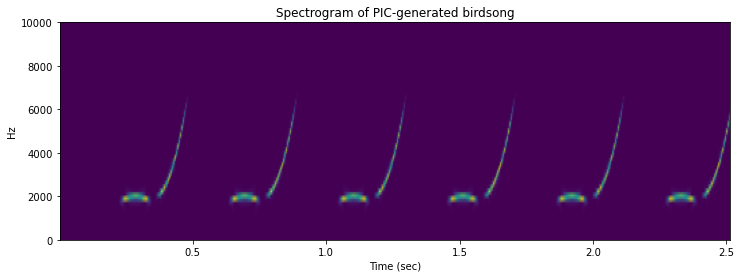

In [19]:
samplerate, data = wavfile.read('./Bird.wav')
frequencies, times, spectrogram = signal.spectrogram((data[80000:191000,0]+data[80000:191000,1])/2., samplerate)
plt.pcolormesh(times, frequencies, spectrogram,  shading='gouraud')
plt.ylabel('Hz'); plt.xlabel('Time (sec)')
plt.title('Spectrogram of PIC-generated birdsong')
plt.ylim([0,10000])
plt.show()